# 2018 NINTENDO SENTIMENT

## Import Relevant Libraries

In [1]:
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import datetime
from datetime import timezone
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from math import pi
import time 
import pickle
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laurashummonmaass/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/laurashummonmaass/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/laurashummonmaass/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Load Tweets to DF

In [2]:
tweets = []
for line in open('NintendoTweets.json', 'r'):
    if len(line)>1:
        tweets.append(json.loads(line))

Flatten json and turn into pandas df.

In [3]:
df = json_normalize(tweets)

## DF Cleaning

In [4]:
len(df)

104695

Select relevant columns

In [5]:
df = df[['user.id', 'text', 'lang', 'created_at', 'timestamp_ms']]

Filter for English only (also uses only relevant columns)  

In [6]:
 df = df.loc[df['lang'] == 'en']

Add a .time. column showing H:M:S    

In [7]:
#outputs str
df['.time.'] = df['created_at'].map(lambda x: x[11:19]) 

In [8]:
#outputs datetime.time
df['datetime'] = df['.time.'].map(lambda x: datetime.datetime.strptime(x, "%H:%M:%S"))
df['datetime'] = df['datetime'].map(lambda x: x.time())

Remove any duplicate rows.

In [9]:
df = df.drop_duplicates(subset=None, keep='first')

## EDA

In [10]:
len(df)

71378

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71378 entries, 0 to 104694
Data columns (total 7 columns):
user.id         71378 non-null float64
text            71378 non-null object
lang            71378 non-null object
created_at      71378 non-null object
timestamp_ms    71378 non-null object
.time.          71378 non-null object
datetime        71378 non-null object
dtypes: float64(1), object(6)
memory usage: 4.4+ MB


In [12]:
df.isna().sum()

user.id         0
text            0
lang            0
created_at      0
timestamp_ms    0
.time.          0
datetime        0
dtype: int64

In [13]:
print(df['.time.'].min())
print(df['.time.'].max())

16:00:24
17:00:23


## Text Cleaning

Remove any words starting with: #, @, or http and put cleaned text into new 'text2' column.

In [14]:
def unique_hashtag_list(df1):
    hashtags = []
    for text in df1['text']:
        words = text.split(' ')
        for i in words:
            if i.startswith('#'):
                hashtags.append(i)
            else:
                pass
    unique_hashtags = set(hashtags)
    unique_hashtags = list(unique_hashtags)
    return unique_hashtags

def unique_link_list(df1):
    links = []
    for text in df1['text']:
        words = text.split(' ')
        for i in words:
            if i.startswith('http'):
                links.append(i)
            else:
                pass
    unique_links = set(links)
    unique_links = list(unique_links)
    return unique_links

def unique_ats_list(df1):
    ats = []
    for text in df1['text']:
        words = text.split(' ')
        for i in words:
            if i.startswith('@'):
                ats.append(i)
            else:
                pass
    unique_ats = set(ats)
    unique_ats = list(unique_ats)
    return unique_ats

In [15]:
def create_text2_without_hash_ats_links(df1):
    words_to_remove_lists = [unique_hashtag_list(df1)] + [unique_link_list(df1)] + [unique_ats_list(df1)]
    words_to_remove = []
    for sublist in words_to_remove_lists:
        for i in sublist:
            words_to_remove.append(i)
    texts_final = []
    for tweet in df1['text']:
        words = tweet.split()
        resultwords = [i for i in words if i not in words_to_remove]
        result = ' '.join(resultwords)
        texts_final.append(result)
    df1['text2'] = texts_final

In [16]:
create_text2_without_hash_ats_links(df)

Remove punctuation

In [17]:
def strip_punctuation(tweet):
    return ''.join(c for c in tweet if c not in string.punctuation)

def remove_punctuation(df1):
    punctuation_free = []
    for tweet in df1['text2']:
        punctuation_free.append(strip_punctuation(tweet))
    df1['text2'] = punctuation_free

In [18]:
remove_punctuation(df)

Make lower case

In [19]:
def make_lower_case(df1):
    lower_case = []
    for tweet in df1['text2']:
        lower_case.append(tweet.lower())
    df1['text2'] = lower_case

In [20]:
make_lower_case(df)

Lemmatize

In [21]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(df1):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tweets = []
    for tweet in df1['text2']:
        lemmatized = [lemmatizer.lemmatize(tweet, get_wordnet_pos(tweet)) for tweet in nltk.word_tokenize(tweet)]
        combined_words = [' '.join(lemmatized)]
        lemmatized_tweets.append(combined_words)
    lemmatized_tweets_final = [''.join(x) for x in lemmatized_tweets]
    df1['text2'] = lemmatized_tweets_final

In [22]:
lemmatize_text(df)

Remove stop words

In [23]:
def remove_stop_words(df1):
    stop_word_free = []
    for tweet in df1['text2']:
        words = tweet.split()
        resultwords = [i for i in words if i not in stopwords.words('english')]
        result = ' '.join(resultwords)
        stop_word_free.append(result)
    df1['text2'] = stop_word_free

In [24]:
remove_stop_words(df)

Remove links again (some links left over if they began with punctuation)

In [25]:
def remove_just_links(df1):
    unique_links2 = set(unique_link_list(df1))
    texts_final_no_http = []
    for tweet in df1['text2']:
        words = tweet.split()
        resultwords = [i for i in words if i not in unique_links2]
        result = ' '.join(resultwords)
        texts_final_no_http.append(result)
    df1['text2'] = texts_final_no_http

In [26]:
remove_just_links(df)

Reset Index

In [27]:
df = df.reset_index()

## Vader Sentiments

In [28]:
def vader_sentiment(df1):
    analyzer = SentimentIntensityAnalyzer()
    vader_output = []
    for tweet in df1['text']:
        vader_output.append(analyzer.polarity_scores(tweet))
    return vader_output

In [29]:
vader_output = vader_sentiment(df)

In [30]:
matrix_df = json_normalize(vader_output)

In [31]:
df = pd.concat([df, matrix_df], axis=1)

## Trend Lines - Grouped by 5 Seconds

In [32]:
def unique_seconds_list(df1):
    '''Creates a list of every unique second in the dataframe's .time. col.'''
    unique_seconds = []
    for times in df1['.time.']:
        all_times = []
        all_times.append(times)
        for i in all_times:
            if not i in unique_seconds:
                unique_seconds.append(i)
    return unique_seconds  

In [33]:
unique_seconds = unique_seconds_list(df)

In [34]:
def second_groupings(seconds, seconds_list):
    '''Returns a list with len equal to the rows of the dataframe.'''
    '''Assigns each tweet to a group dependant on it's time.'''
    second_groups = []
    for second in seconds_list:
        if len(second_groups)==0:
            second_groups.append(1)
        elif len(second_groups)%seconds != 0:
            second_groups.append(second_groups[-1])
        else:
            second_groups.append(second_groups[-1]+1)
    return second_groups # creates a list to be mapped back to the df for grouping

In [35]:
list_of_second_groups = second_groupings(5, unique_seconds)

In [36]:
seconds_dict = dict(zip(unique_seconds, list_of_second_groups))

Use the dictionary above to assign each tweet to a 5 second group

In [37]:
df['5_seconds'] = df['.time.'].map(seconds_dict)

Trend line

In [38]:
def trend_line_by_5_sec(df1, sum_mean='sum'):    
    #sum or mean
    if sum_mean=='sum':
        trend_df = df1.groupby('5_seconds').sum() 
    elif sum_mean=='mean':
        trend_df = df1.groupby('5_seconds').mean() 
    trend_df = trend_df.reset_index()   
    #invert negative sentiments
    trend_df['neg'] = trend_df['neg'].map(lambda x: x * -1)
    #plotting trend graph
    plt.plot(trend_df['5_seconds'], trend_df['pos'], color='red')
    plt.plot(trend_df['5_seconds'], trend_df['neg'], color='grey')
    plt.xlabel('Every 5 Seconds')
    plt.ylabel('Sentiment')
    plt.title('Nintendo E3 Twitter Sentiments (sum)')
    plt.legend()
    plt.show()

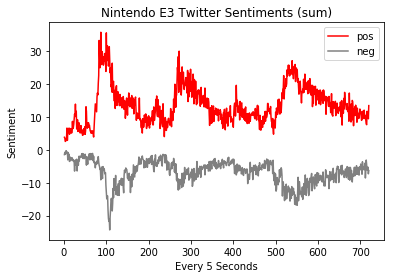

In [39]:
trend_line_by_5_sec(df)

## Trend Lines - With Time Selector

In [40]:
def dict_by_index_of_filtered_times(df1,
                                    start_time_str='16:07:24', 
                                    end_time_str='16:10:46'):
    #print(start_time_str, end_time_str)
    every_index = df1['index']
    #convert input strings to datetime.time
    start_time = datetime.datetime.strptime(start_time_str, "%H:%M:%S")
    start_time = start_time.time()
    end_time = datetime.datetime.strptime(end_time_str, "%H:%M:%S")
    end_time = end_time.time()
    #filters by time (returns in True/False)
    specific_times = (df1['datetime'] > start_time) & (df1['datetime'] <= end_time)
    #converting True False to boolean
    specific_times_final = []
    for i in specific_times:
        if i == False:
            specific_times_final.append(0)
        elif i == True:
            specific_times_final.append(1)
    
    times_dict = dict(zip(every_index, specific_times_final))
    times_only_dict = dict((k, v) for k, v in times_dict.items() if v == 1)
    return times_only_dict

In [53]:
def trend_line_by_time(df1, 
                  start_time_str='16:07:24', 
                  end_time_str='16:10:36',
                  sum_mean='sum'
                 ):
    '''Returns a trend line using start and end times'''
    criteria = dict_by_index_of_filtered_times(df1, 
                                    start_time_str=start_time_str,
                                    end_time_str=end_time_str)
    if 'temp_criteria_col' not in df1.columns:
        pass
    else:
        df1.drop(['temp_criteria_col'], axis=1)
    df1['temp_criteria_col'] = df1['index'].map(criteria)
    df1['temp_criteria_col'].fillna(0, inplace=True)
    if sum_mean == 'sum':
        trend_df = df1.loc[df1['temp_criteria_col'] == 1]
        trend_df = trend_df.groupby('datetime').sum()
    elif sum_mean == 'mean':
        trend_df = df1.loc[df1['temp_criteria_col'] == 1]
        trend_df = trend_df.groupby('datetime').mean()
    #NEW LINE -- negate trend_df['neg']
    trend_df['neg'] = trend_df['neg'].map(lambda x: x * -1)
    #plot trend_line
    plt.plot(trend_df['pos'], color='red')
#ax.plot()
#fig,ax = plt.subplots()
    plt.plot(trend_df['neg'], color='grey')
    plt.xlabel('Seconds')
    plt.ylabel('Sentiment')
    plt.title('Nintendo E3 Twitter Sentiments (sum)')
    plt.legend()
    return plt.show()

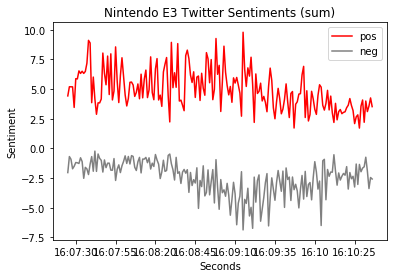

In [54]:
trend_line_by_time(df)

## Radar Plots - With Time Selector

In [43]:
#FIRST
def unique_words_list(df1):
    '''Creates a list of every unique word in the text2 column of the df.'''
    total_words = []
    for i in df1['text2']:
        words = i.split()
        for j in words:
            total_words.append(j)
    unique_words = [] 
    for i in total_words:
        if not i in unique_words:
            unique_words.append(i)
    return unique_words

In [44]:
#SECOND
def vectorize_to_matrix_df(df1):
    '''Creates a dataframe of sentiments (each word is a col)'''
    vectorizer = CountVectorizer(vocabulary=unique_words_list(df1))
    vectorized_words = vectorizer.transform(df1['text2'])
    word_array = vectorized_words.toarray()
    matrix_df = pd.DataFrame(word_array, columns=unique_words_list(df1), index=df1.index) 
    return matrix_df

In [45]:
#THIRD
def words_df(df1):
    '''Merges the words dataframe to the original df.'''
    #get column headings ready, don't want duplicates with text
    df = df1.rename(index=str, columns={"text": ".text.", "lang": ".lang.", "time":".time."})
    #remove index and reset index
    df = df.drop('index', 1)
    df = df.reset_index()
    df = df.rename(index=str, columns={'index': 'df_index'})
    #create a matrix dataframe of words
    matrix_df = vectorize_to_matrix_df(df1).reset_index()
    matrix_df = matrix_df.rename(index=str, columns={'index': 'matrix_df_index'})
    df_words = df.join(matrix_df)
    return df_words

In [46]:
#FOURTH
# must be used with words_df as df1... needs to have words as cols included
def create_dictionary_for_specified_time (df1, which_five='top'): #time=1, seconds=5, which_five='top'): # choose either 'top' or 'bottom'
    '''Outputs dict of top or bottom 5 words per compound sum'''
    #filters df by time (temp_criteria_col is 1 if its in time range)
    df_filtered_by_temp_col = df1.loc[(df1['temp_criteria_col']== 1)]  #| (df_words['five_seconds']== 2)]
    #makes a dictionary of dictionary where main key is seconds
    dict_by_seconds = df_filtered_by_temp_col.to_dict(orient='index') 
    #create a cleaned dictionary for each word labeled by tweet number
    list_of_word_dicts = []
    for key1, val in dict_by_seconds.items():
        u_words = val['text2'].split(' ')
        neg = val['neg']
        compound = val['compound']
        neu = val['neu']
        pos = val['pos']
        for key, value in val.items():
            try:
                value = float(value)
                if (value > 0) & (key in u_words) :
                    list_of_word_dicts.append({ 
                            'tweet_no': key1,
                            key:{'count': 1, 'compound_sum': compound, 'neg_sum': neg, 
                                 'neu_sum': neu, 'pos_sum': pos},
                                                })
            except:
                pass  
    # remove duplicate words that appear several times in one tweet
    no_dupl_list_of_word_dicts = [i for n, i in enumerate(list_of_word_dicts) 
                                  if i not in list_of_word_dicts[n + 1:]]    
    return_dict = {}
    for i in no_dupl_list_of_word_dicts:
        for key, val in i.items():
            if key is not 'tweet_no':
                if key not in return_dict.keys():
                    return_dict.update({key : val})
                else:
                    return_dict[key]['count'] += val['count']
                    return_dict[key]['compound_sum'] += val['compound_sum']
                    return_dict[key]['neg_sum'] += val['neg_sum']
                    return_dict[key]['neu_sum'] += val['neu_sum']
                    return_dict[key]['pos_sum'] += val['pos_sum']                   
    compound_dict = {}
    for key, val in return_dict.items():
        #print(key, val)
        #compound_dict.update({key: val['compound_sum'] })
        compound_dict[key] = val['compound_sum']
    sorted_compound_dict = sorted(compound_dict.items(), key=lambda kv: kv[1])   
    if which_five == 'top':
        #five_words = dict(sorted_compound_dict[0:5])
        five_words = dict(sorted_compound_dict[-5:])
    elif which_five == 'bottom': 
        #five_words = dict(sorted_compound_dict[-5:])
        five_words = dict(sorted_compound_dict[0:5])
    else:
        "Please choose either 'top' or 'bottom'."
    return five_words

In [47]:
#FIFTH
def top_5_dict_to_df(df1, which_five='top'):  
    '''Outputs the top/bottom 5 words into a df, formatted for radar plot'''
    top_5_df = pd.Series(create_dictionary_for_specified_time(df1, 
                                                              which_five=which_five))
    top_5_df = pd.DataFrame(top_5_df)
    top_5_df = top_5_df.T
    top_5_df['group'] = 'A'
    return top_5_df

In [48]:
#SIXTH
def output_radar_plot(df1, which_five='top'):
    '''Returns a radar plot'''
    # Set data
    radar_df = top_5_dict_to_df(df1,
                                         which_five=which_five)
    # Make negative values positive
    if which_five=='bottom':
        radar_df = radar_df.apply(lambda x: x * -1)
    else:
        pass
    # Find largest score, will affect radar plot size
    dictionary = create_dictionary_for_specified_time(df1,
                                                         which_five=which_five)
    list_of_scores = []
    for k, v in dictionary.items():
        list_of_scores.append(v)
    if which_five=='top':
        relevant_score = max(list_of_scores)
    elif which_five=='bottom':
        relevant_score = (min(list_of_scores))*-1
    # number of variable
    categories=list(radar_df)[1:]
    N = len(categories)
    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values=radar_df.loc[0].drop('group').values.flatten().tolist()
    values += values[:1]
    values
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0,(relevant_score*.33),(relevant_score*.66),(relevant_score)], 
               [0, "", "", ""], color="grey", size=7)
    plt.ylim(0,(relevant_score))
    # Plot data
    if which_five == 'top':
        ax.plot(angles, values, linewidth=1, linestyle='solid', color='red')
    elif which_five == 'bottom':
        ax.plot(angles, values, linewidth=1, linestyle='solid', color='grey')
    # Fill area
    if which_five == 'top':
        radar_plot = ax.fill(angles, values, 'red', alpha=0.1);  
    elif which_five == 'bottom':
        radar_plot = ax.fill(angles, values, 'grey', alpha=0.1);    
    return radar_plot

In [49]:
#SEVENTH
def automating_radar_plots(df1, 
                           start_time='16:07:24', 
                           end_time='16:08:36', 
                           which_five='top'):
    '''Turns original df into radar plot.'''
    criteria = dict_by_index_of_filtered_times(df1, 
                                            start_time_str=start_time,
                                            end_time_str=end_time)
    if 'temp_criteria_col' not in df1.columns:
        pass
    else:
        df1.drop(['temp_criteria_col'], axis=1)
    #df = df1.drop(['temp_criteria_col'], axis=1)
    df1['temp_criteria_col'] = df1['index'].map(criteria)
    df1['temp_criteria_col'].fillna(0, inplace=True)
    word_df=words_df(df1) 
    return output_radar_plot(word_df,which_five=which_five)

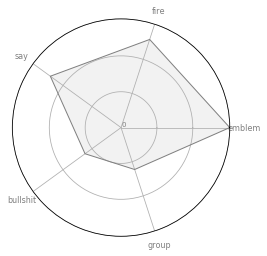

In [51]:
automating_radar_plots(df, 
                           start_time='16:07:24', 
                           end_time='16:08:36', 
                           which_five='bottom')